<a href="https://colab.research.google.com/github/Louisfhgr/Dash.py/blob/master/SUGO_RNN_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Projekt SUGO RNN


In [2]:
%pip install meteostat

In [3]:
!pip install files
!pip install openpyxl

  Preparing metadata (setup.py) ... done
  Created wheel for files: filename=files-1.1.1-py3-none-any.whl size=3649 sha256=c2940f13621ef6abe511aec08f484b37f09026da241abcf443f02ffda2f71855
  Stored in directory: /root/.cache/pip/wheels/7b/5a/b5/b363f1d4d991bd2a9199fd2bf46574a5477c0c7f8a22881848
Successfully built files


In [2]:
import sys
import pandas as pd
import random
import numpy as np
import requests
from datetime import datetime, timedelta
import os
#from google.colab import files
from meteostat import Point, Daily
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt


import openpyxl

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [5]:
print(sys.path)

print(f"Python Version: {sys.version}")

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython']
Python Version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


### Datenfluss

#### Datenfluss automatisiert

Wetterdaten

Swiss Meteo erst ab 2025 möglich

In [37]:
# Standort  (St. Gallen, Schweiz)
location = Point(47.4239, 9.3748)

# Zeitraum 2022-2024
start = datetime(2022, 1, 1)
end = datetime(2024, 8, 25)

data = Daily(location, start, end)
data = data.fetch()

# Die 'date' Spalte hinzufügen (aus dem Index extrahieren)
data['date'] = data.index

# Ordner erstellen, falls er nicht existiert
folder_path = 'csv_Daten'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Dateipfad für die CSV-Datei
file_path = os.path.join(folder_path, 'st_gallen_weather_2022_2023_2024_years_meteostat.csv')

# Daten in CSV speichern
data.to_csv(file_path, index=False)



print(f"Die Wetterdaten wurden erfolgreich in '{file_path}' gespeichert.")


Die Wetterdaten wurden erfolgreich in 'csv_Daten/st_gallen_weather_2022_2023_2024_years_meteostat.csv' gespeichert.


#### Datenfluss manuell (csv)

##### SAP

### Aufbau Ordner

In [39]:
# Ordnerstruktur ausgeben
print("Aktueller Ordneraufbau:")
for root, dirs, files in os.walk('.'):
    level = root.replace('.', '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{sub_indent}{f}")

Aktueller Ordneraufbau:
./
    .config/
        .last_opt_in_prompt.yaml
        hidden_gcloud_config_universe_descriptor_data_cache_configs.db
        config_sentinel
        default_configs.db
        .last_survey_prompt.yaml
        gce
        .last_update_check.json
        active_config
        configurations/
            config_default
        logs/
            2024.09.25/
                18.23.16.379542.log
                18.23.58.041880.log
                18.23.40.958965.log
                18.23.56.396629.log
                18.24.13.190037.log
                18.24.13.969738.log
    csv_Daten/
        Query_ZSD_917_1070_allarticle_2022_2023_2024_anonym_version_Z05_Kunde.XLSX
        MCSI_1070article_2022_2023_2024_anonym_Auftra_Material_Ve_Datum_NetGew_NetGew.xlsx
        Query_ZPP_005_allarticle_1070_anonym.xlsx
        st_gallen_weather_2022_2023_2024_years_meteostat.csv
        .ipynb_checkpoints/
    sample_data/
        anscombe.json
        README.md
        mnist_tr

### Explorative Datenanalyse

Wetterdaten


In [41]:
# Dateipfad für die CSV-Datei
file_path = 'csv_Daten/st_gallen_weather_2022_2023_2024_years_meteostat.csv'

# Daten als DataFrame laden
df_weather = pd.read_csv(file_path)



print(df_weather.head())

   tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun        date
0  10.2   8.2  12.2   NaN   NaN  168.0   4.1  22.2  1029.6   NaN  2022-01-01
1  10.1   7.1  12.5   NaN   NaN  206.0   7.2  42.6  1024.8   NaN  2022-01-02
2   9.5   8.7  11.5   NaN   NaN  225.0  13.4  44.5  1020.1   NaN  2022-01-03
3  10.8   6.6  13.9   NaN   NaN  227.0  13.7  51.8  1004.0   NaN  2022-01-04
4   0.3  -2.4   5.8   NaN   NaN  240.0  12.0  38.9  1011.7   NaN  2022-01-05


In [42]:
print(df_weather.describe())
print(df_weather.columns)

             tavg        tmin        tmax  prcp  snow        wdir        wspd  \
count  956.000000  956.000000  956.000000   0.0   0.0  956.000000  956.000000   
mean    10.466946    7.773849   13.470188   NaN   NaN  165.268828    7.750209   
std      7.308757    6.792755    8.071588   NaN   NaN   74.862246    3.566674   
min     -7.200000   -9.100000   -5.900000   NaN   NaN    5.000000    1.900000   
25%      5.100000    3.100000    7.700000   NaN   NaN   93.000000    5.500000   
50%     10.200000    7.600000   13.200000   NaN   NaN  192.000000    6.900000   
75%     16.800000   13.700000   20.525000   NaN   NaN  223.250000    9.100000   
max     25.700000   22.300000   30.200000   NaN   NaN  358.000000   30.100000   

             wpgt         pres  tsun  
count  956.000000   956.000000   0.0  
mean    27.325314  1017.766423   NaN  
std     12.767953     8.262288   NaN  
min      5.500000   985.600000   NaN  
25%     18.500000  1013.475000   NaN  
50%     24.100000  1017.600000   NaN

* time: Datum der Messung
* tavg: Durchschnittstemperatur (°C)
* tmin: Minimale Temperatur (°C)
* tmax: Maximale Temperatur (°C)
* prcp: Niederschlag (mm)
* snow: Schneefall (mm)
* wdir: Windrichtung (Grad)
* wspd: Windgeschwindigkeit (km/h)
* wpgt: Maximale Windböengeschwindigkeit (km/h)
* pres: Luftdruck (hPa)
* tsun: Sonnenscheindauer (Minuten)

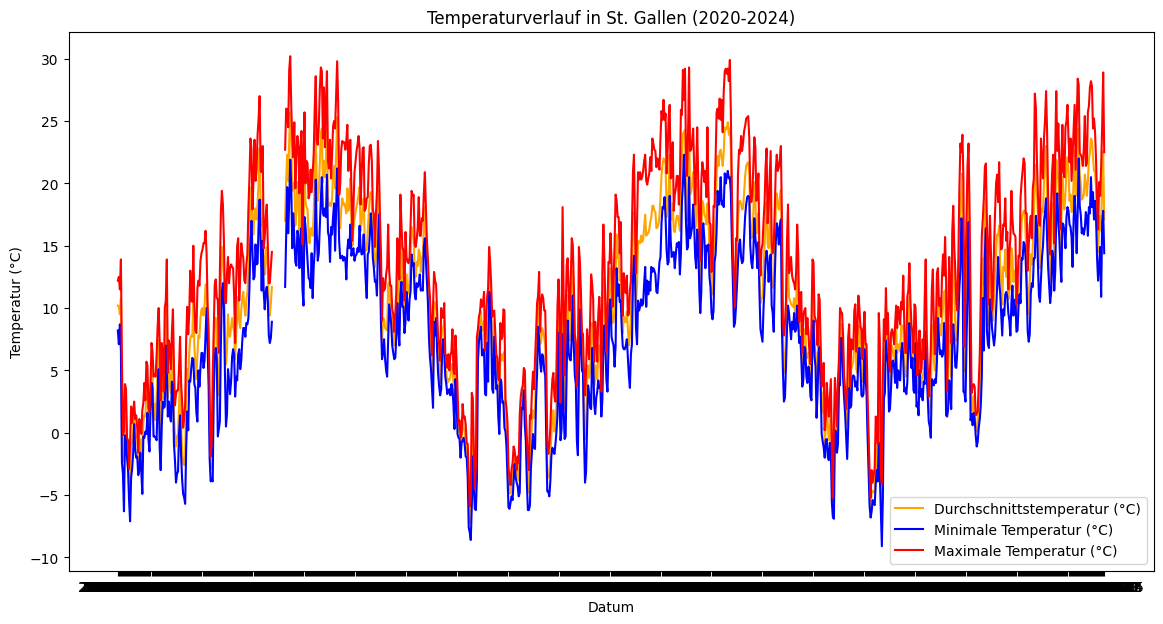

In [43]:
plt.figure(figsize=(14, 7))
plt.plot(df_weather['date'], df_weather['tavg'], label='Durchschnittstemperatur (°C)', color='orange')
plt.plot(df_weather['date'], df_weather['tmin'], label='Minimale Temperatur (°C)', color='blue')
plt.plot(df_weather['date'], df_weather['tmax'], label='Maximale Temperatur (°C)', color='red')
plt.xlabel('Datum')
plt.ylabel('Temperatur (°C)')
plt.title('Temperaturverlauf in St. Gallen (2022-2024)')
plt.legend()
plt.show()


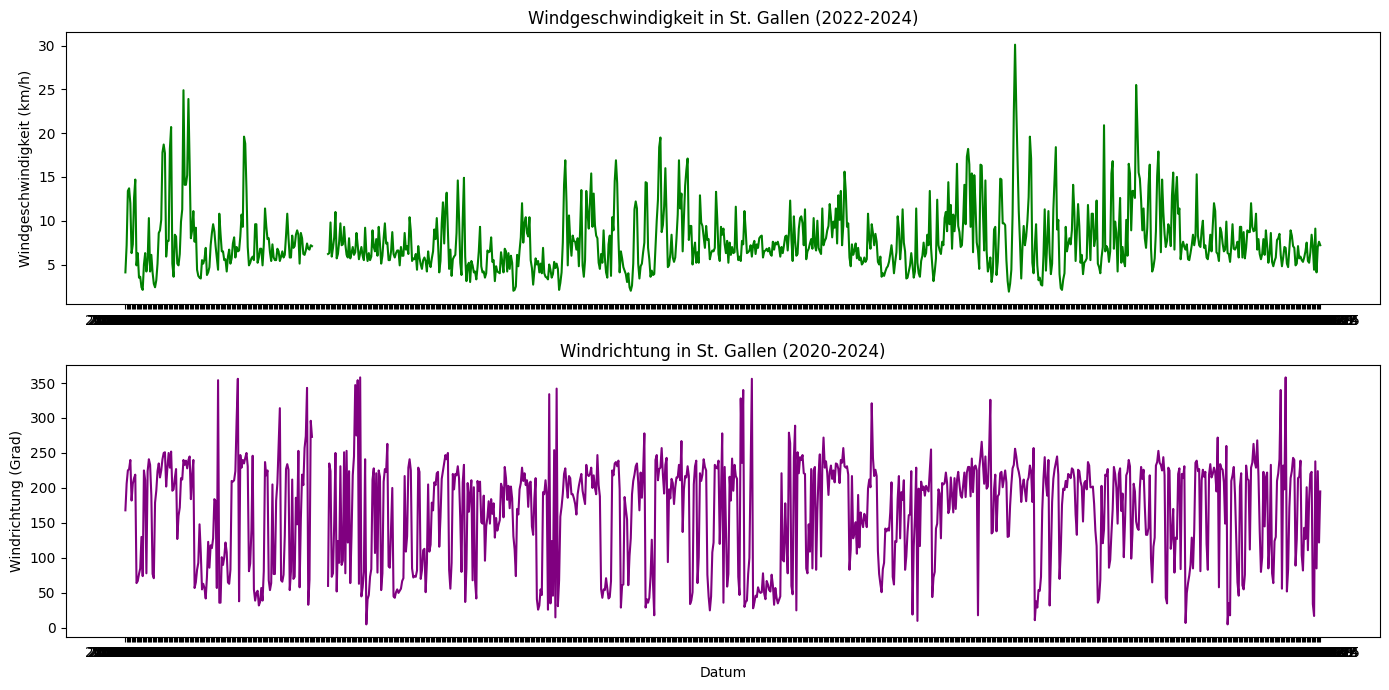

In [44]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(df_weather['date'], df_weather['wspd'], label='Windgeschwindigkeit (km/h)', color='green')
plt.ylabel('Windgeschwindigkeit (km/h)')
plt.title('Windgeschwindigkeit in St. Gallen (2022-2024)')

plt.subplot(2, 1, 2)
plt.plot(df_weather['date'], df_weather['wdir'], label='Windrichtung (Grad)', color='purple')
plt.xlabel('Datum')
plt.ylabel('Windrichtung (Grad)')
plt.title('Windrichtung in St. Gallen (2022-2024)')

plt.tight_layout()
plt.show()

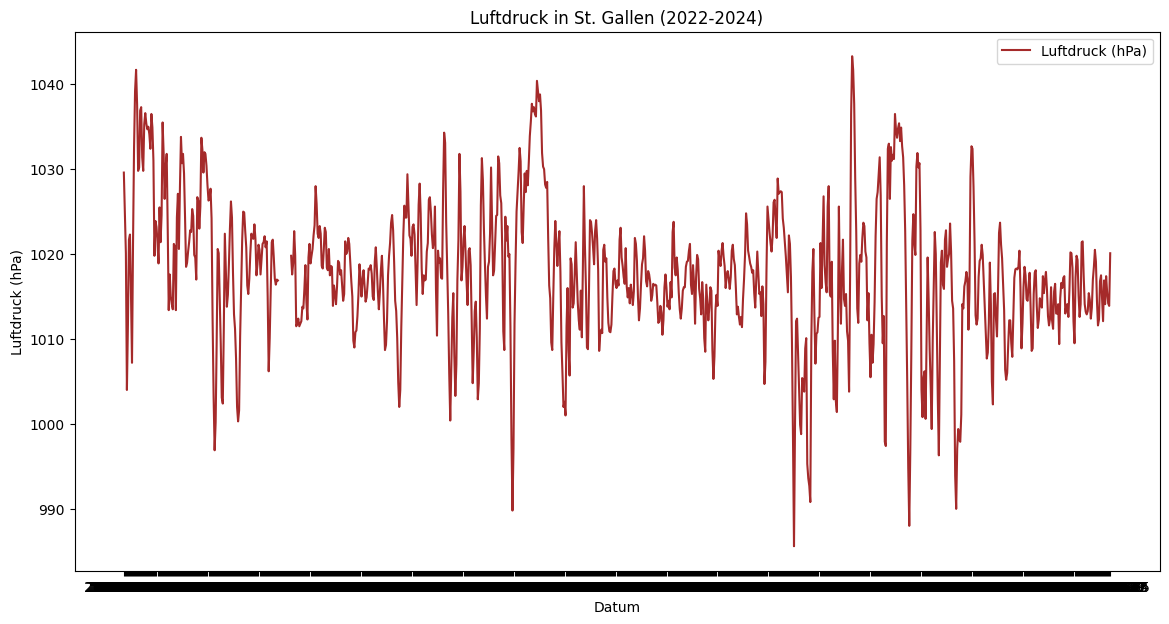

In [45]:
plt.figure(figsize=(14, 7))
plt.plot(df_weather['date'], df_weather['pres'], label='Luftdruck (hPa)', color='brown')
plt.xlabel('Datum')
plt.ylabel('Luftdruck (hPa)')
plt.title('Luftdruck in St. Gallen (2022-2024)')
plt.legend()
plt.show()

SUGO Artikel SAP (2022-2024)



In [14]:
# Dateipfad für die CSV-Datei
file_path = 'csv_Daten/MCSI_1070article_2022_2023_2024_anonym_Auftra_Material_Ve_Datum_NetGew_NetGew.xlsx'

# Daten als DataFrame laden
df_sold = pd.read_excel(file_path)

print(df_sold.head())
print(df_sold.count())


   Auftra  Material  Ve       Datum  NetGew NetGew.1
0      21     24291   4  31.07.2024    0.00       KG
1      21     24291   4  02.08.2024    0.00       KG
2      21     24291   4  03.08.2024    1.50       KG
3      21     24291   4  31.08.2024    0.00       KG
4      21     24292   4  08.08.2024    2.25       KG
Auftra      782824
Material    782824
Ve          782824
Datum       782824
NetGew      782824
NetGew.1    782824
dtype: int64


In [36]:
# Konvertiere die 'Datum'-Spalte in das Datumsformat
df_sold['Datum'] = pd.to_datetime(df_sold['Datum'], format='%d.%m.%Y')


# NetGew.1 entfernen
df_sold = df_sold.drop(columns=['NetGew.1'])

print(df_sold.head())

KeyError: "['NetGew.1'] not found in axis"

In [47]:
print(df_sold.head())
print(df_sold.columns)

   Auftra  Material  Ve      Datum  NetGew
0      21     24291   4 2024-07-31    0.00
1      21     24291   4 2024-08-02    0.00
2      21     24291   4 2024-08-03    1.50
3      21     24291   4 2024-08-31    0.00
4      21     24292   4 2024-08-08    2.25
Index(['Auftra', 'Material', 'Ve', 'Datum', 'NetGew'], dtype='object')


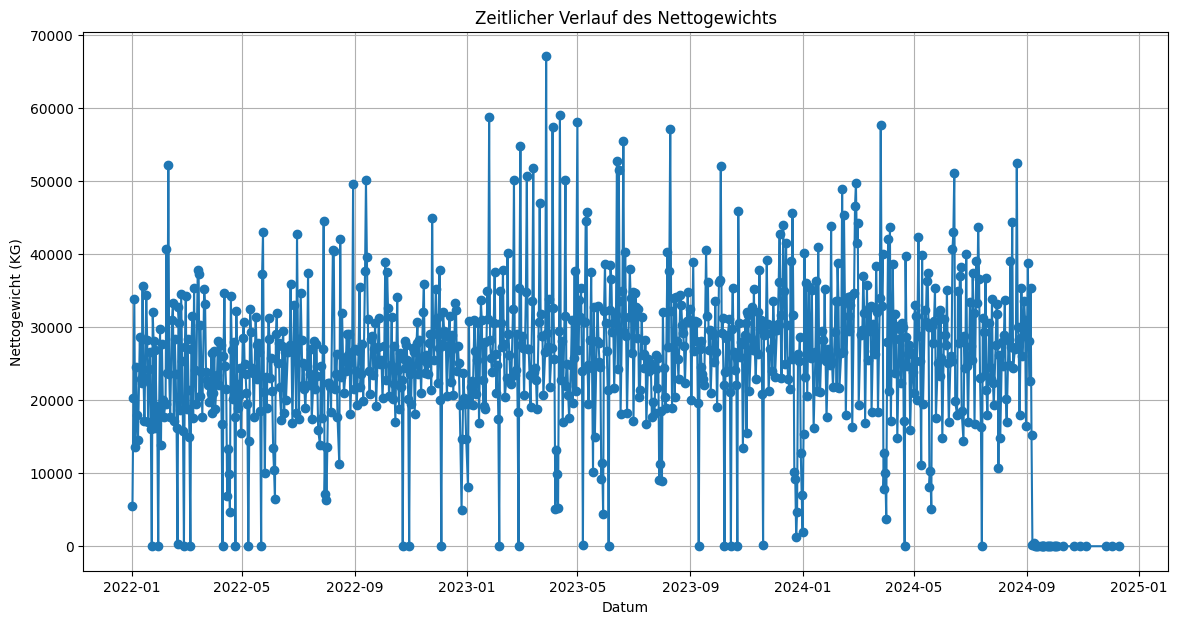

In [17]:
# Gruppierung der Daten nach Datum und Aggregation des Nettogewichts
df_sold_grouped = df_sold.groupby('Datum')['NetGew'].sum().reset_index()

# Zeitlicher Verlauf des Nettogewichts
plt.figure(figsize=(14, 7))
plt.plot(df_sold_grouped['Datum'], df_sold_grouped['NetGew'], marker='o')
plt.title('Zeitlicher Verlauf des Nettogewichts')
plt.xlabel('Datum')
plt.ylabel('Nettogewicht (KG)')
plt.grid(True)
plt.show()

            Auftra  Material        Ve     Datum    NetGew
Auftra    1.000000 -0.009933  0.031218 -0.005071 -0.017901
Material -0.009933  1.000000  0.062671  0.002937  0.051666
Ve        0.031218  0.062671  1.000000  0.102861  0.048700
Datum    -0.005071  0.002937  0.102861  1.000000  0.002883
NetGew   -0.017901  0.051666  0.048700  0.002883  1.000000


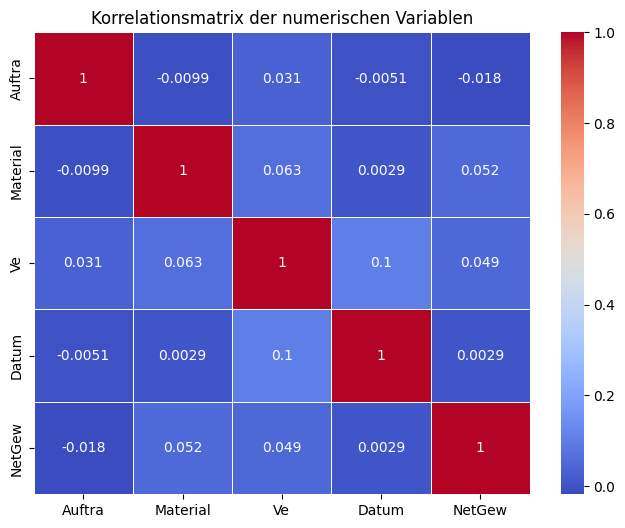

In [18]:
# Korrelation zwischen den numerischen Variablen
correlation_matrix = df_sold.corr()

print(correlation_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Korrelationsmatrix der numerischen Variablen')
plt.show()

Ve                1          2    3          4         5
Material                                                
1060       11998.22  12394.200  NaN   25901.70       NaN
1061      194815.10  31521.655  NaN  368108.20  53450.40
1062        4381.60   1885.800  NaN   83476.65       NaN
1066         224.10        NaN  NaN        NaN    123.60
1069        9585.90        NaN  NaN   10467.50  13468.59
...             ...        ...  ...        ...       ...
700050       220.80        NaN  NaN       0.00   9771.50
700051          NaN        NaN  NaN        NaN   1440.70
700052       160.30        NaN  NaN        NaN  39623.87
700192          NaN        NaN  0.8        NaN       NaN
1125012         NaN     42.000  0.2      72.78       NaN

[672 rows x 5 columns]


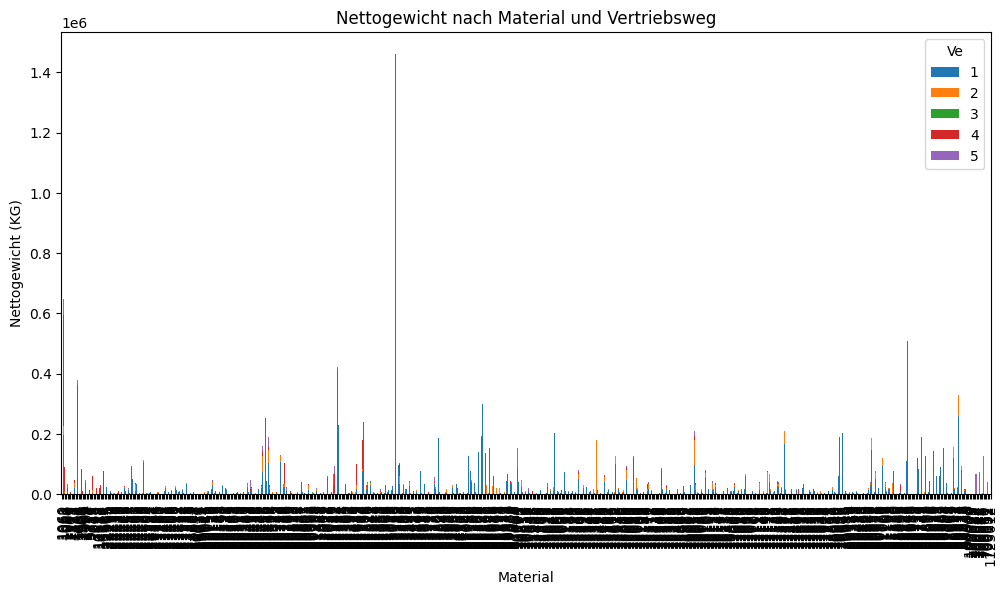

In [19]:
# Pivot-Tabelle für Material und Ve
pivot_table = df_sold.pivot_table(values='NetGew', index='Material', columns='Ve', aggfunc='sum')

print(pivot_table)


pivot_table.plot(kind='bar', figsize=(12, 6), stacked=True)
plt.title('Nettogewicht nach Material und Vertriebsweg')
plt.ylabel('Nettogewicht (KG)')
plt.show()

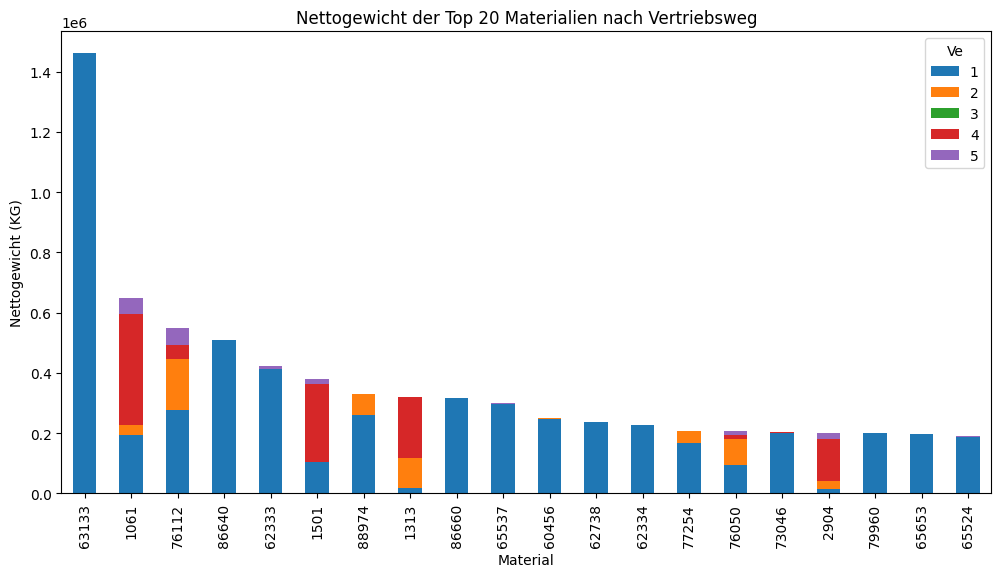

In [21]:
# Filtern der Pivot-Tabelle auf die Top 20 Materialien
pivot_table = df_sold.pivot_table(values='NetGew', index='Material', columns='Ve', aggfunc='sum')

top_20_materials = pivot_table.sum(axis=1).nlargest(20).index


pivot_table_top_20 = pivot_table.loc[top_20_materials]

# Visualisierung der Pivot-Tabelle (Top 20 Artikel)
pivot_table_top_20.plot(kind='bar', figsize=(12, 6), stacked=True)
plt.title('Nettogewicht der Top 20 Materialien nach Vertriebsweg')
plt.ylabel('Nettogewicht (KG)')
plt.show()

#### KEPM

In [48]:
# Dateipfad für die CSV-Datei
file_path = 'csv_Daten/Query_ZSD_917_1070_allarticle_2022_2023_2024_anonym_version_Z05_Kunde.XLSX'

# Daten als DataFrame laden
df_kepm = pd.read_excel(file_path)

print(df_kepm.head())
print(df_kepm.count())

print(df_kepm.columns)

  Versi  Kunde  Artikel  Gültig ab Gültig bis  Menge in KG
0   Z05  600.0  12872.0 2022-01-01 2022-01-07        600.0
1   Z05  600.0  24395.0 2022-01-01 2022-01-07        800.0
2   Z05  600.0  21513.0 2022-01-01 2022-01-07       3850.0
3   Z05  600.0  88978.0 2022-01-01 2022-01-07        172.5
4   Z05  600.0  88977.0 2022-01-01 2022-01-07        390.0
Versi          44560
Kunde          17351
Artikel        44560
Gültig ab      44560
Gültig bis     44560
Menge in KG    44561
dtype: int64
Index(['Versi', 'Kunde', 'Artikel', 'Gültig ab', 'Gültig bis', 'Menge in KG'], dtype='object')


In [ ]:
df_kepm_cleaned = df_kepm.iloc[:-1]

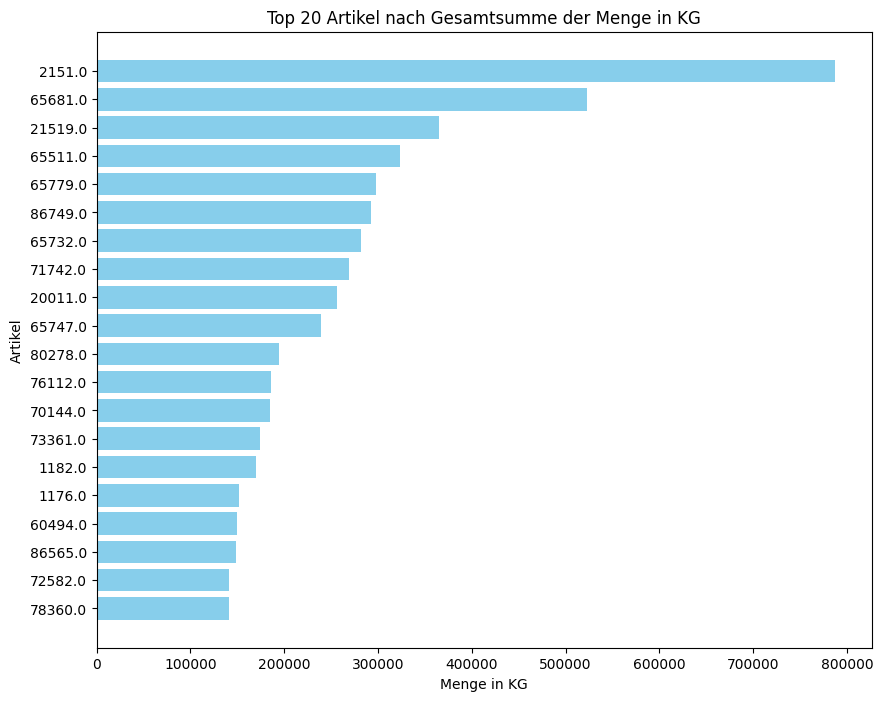

In [35]:

df_grouped = df_kepm_cleaned.groupby("Artikel")["Menge in KG"].sum().reset_index()

# Sortiere nach "Menge in KG" absteigend und wähle die Top 20 Artikel
df_top20 = df_grouped.sort_values(by="Menge in KG", ascending=False).head(20)

# Erstelle das horizontale Balkendiagramm
plt.figure(figsize=(10, 8))
plt.barh(df_top20["Artikel"].astype(str), df_top20["Menge in KG"], color='skyblue')  # Artikel als String für bessere Lesbarkeit
plt.xlabel("Menge in KG")
plt.ylabel("Artikel")
plt.title("Top 20 Artikel nach Gesamtsumme der Menge in KG")
plt.gca().invert_yaxis()  # Größter Wert oben
plt.show()

### Prüfung der Stationarität

## KI Modelle

### RNN

Daten kombinieren


In [4]:
weather_file_path = 'csv_Daten/st_gallen_weather_2022_2023_2024_years_meteostat.csv'

sales_file_path = 'csv_Daten/MCSI_1070article_2022_2023_2024_anonym_Auftra_Material_Ve_Datum_NetGew_NetGew.xlsx'

kepm_file_path = 'csv_Daten/Query_ZSD_917_1070_allarticle_2022_2023_2024_anonym_version_Z05_Kunde.XLSX'




# 1. Wetterdaten laden
df_weather = pd.read_csv(weather_file_path)
df_weather['date'] = pd.to_datetime(df_weather['date'])  # Datum in datetime umwandeln

# Filtern der Wetterdaten zwischen 2022 und 2024
df_weather = df_weather[(df_weather['date'] >= '2022-01-01') & (df_weather['date'] <= '2024-08-25')]

# 2. Verkaufsdaten laden
df_sales = pd.read_excel(sales_file_path)
df_sales['Datum'] = pd.to_datetime(df_sales['Datum'])  # Datum in datetime umwandeln

# Filtern der Verkaufsdaten zwischen 2022 und 2024
df_sales = df_sales[(df_sales['Datum'] >= '2022-01-01') & (df_sales['Datum'] <= '2024-08-25')]

# 3. KEPM-Daten laden
df_kepm = pd.read_excel(kepm_file_path)
df_kepm['Gültig ab'] = pd.to_datetime(df_kepm['Gültig ab'])  # "Gültig ab" in datetime umwandeln
df_kepm['Gültig bis'] = pd.to_datetime(df_kepm['Gültig bis'])  # "Gültig bis" in datetime umwandeln

# Filtern der KEPM-Daten
df_kepm = df_kepm[(df_kepm['Gültig ab'] >= '2022-01-01') & (df_kepm['Gültig bis'] <= '2024-08-25')]


In [2]:
import pandas as pd

# Kombiniere die Wetter- und Verkaufsdaten anhand Datum
df_combined = pd.merge(df_weather, df_sales, left_on='date', right_on='Datum', how='inner')

# Füge die KEPM-Daten anhand des Zeitraums hinzu
df_combined_kepm = pd.merge(df_combined, df_kepm, left_on='Datum', right_on='Gültig ab', how='left')



NameError: name 'df_weather' is not defined

In [1]:
df_combined_kepm

NameError: name 'df_combined_kepm' is not defined

Datenvorbereitung für das RNN

RNN-Modell (wie LSTM oder GRU)

### Forecasting using ARIMA

### Hold winters

## Modell Evaluation